In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-16 01:25:15.491715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 01:25:15.506827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [13]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [14]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [15]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [16]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [17]:
# Variables to reuse
model_dim = 10
model_epc = 125

# Reducing with Convolutional Topological Autoencoders

In [18]:
model_lam = 1
model_dim = 10
model_epc = 1500
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='ConvolutionalAutoencoder_custom_dim2',
    lam = model_lam,
    ae_kwargs = {'input_dims':(1, 180), 'custom_dim':model_dim},
    input_shape = (-1, 1, 1, 180),
    patience = None,
    num_epochs = model_epc
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim2
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


In [19]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim2
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


Epoch:1, P:None, Loss:2624.0276, Loss-ae:2624.0241, Loss-topo:0.0035
Epoch:2, P:None, Loss:2600.2223, Loss-ae:2600.2214, Loss-topo:0.0009
Epoch:3, P:None, Loss:2626.3529, Loss-ae:2626.3523, Loss-topo:0.0005
Epoch:4, P:None, Loss:2609.7589, Loss-ae:2609.7581, Loss-topo:0.0008
Epoch:5, P:None, Loss:2585.0352, Loss-ae:2585.0347, Loss-topo:0.0004
Epoch:6, P:None, Loss:2598.1977, Loss-ae:2598.1973, Loss-topo:0.0005
Epoch:7, P:None, Loss:2600.7626, Loss-ae:2600.7621, Loss-topo:0.0005
Epoch:8, P:None, Loss:2598.1048, Loss-ae:2598.1045, Loss-topo:0.0003
Epoch:9, P:None, Loss:2608.4386, Loss-ae:2608.4382, Loss-topo:0.0004
Epoch:10, P:None, Loss:2617.4070, Loss-ae:2617.4064, Loss-topo:0.0007
Epoch:11, P:None, Loss:2591.6142, Loss-ae:2591.6137, Loss-topo:0.0005
Epoch:12, P:None, Loss:2603.3578, Loss-ae:2603.3574, Loss-topo:0.0005
Epoch:13, P:None, Loss:2577.6387, Loss-ae:2577.6381, Loss-topo:0.0006
Epoch:14, P:None, Loss:2595.8964, Loss-ae:2595.8960, Loss-topo:0.0004
Epoch:15, P:None, Loss:2602.8

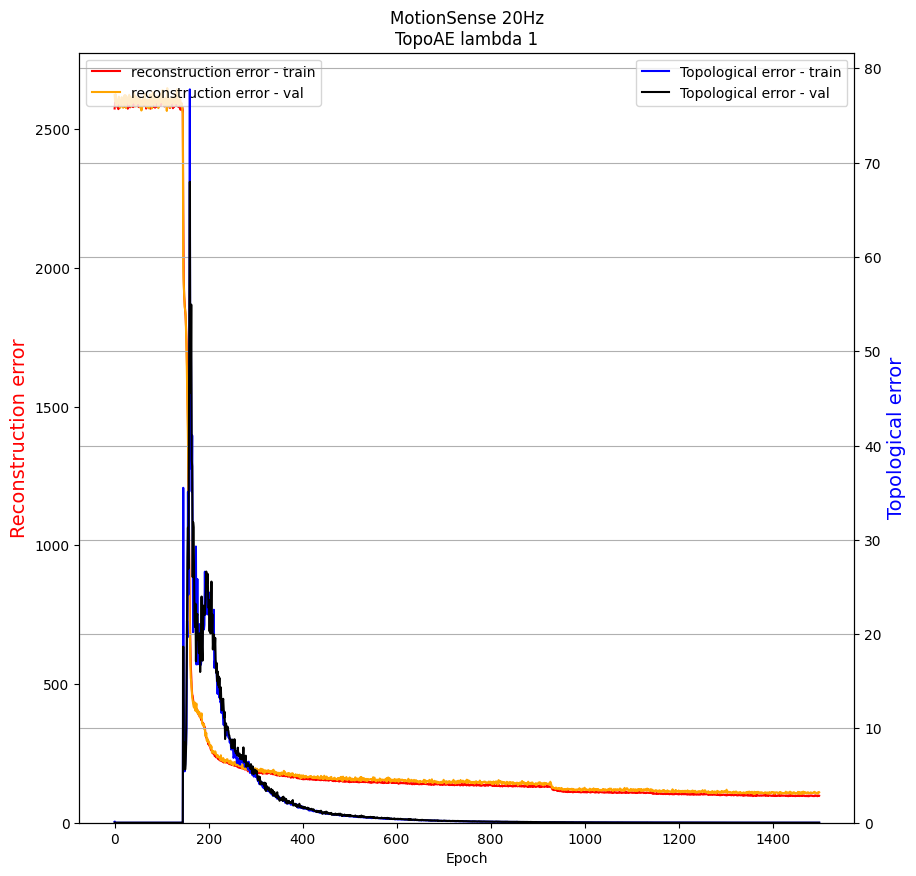

In [20]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [21]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [22]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [23]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8299999999999998,
 'RF-F1': 0.8273908973825199,
 'SVC-ACC': 0.8931372549019608,
 'SVC-F1': 0.8928722407029736,
 'KNN-ACC': 0.7852941176470588,
 'KNN-F1': 0.7822274501881106}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


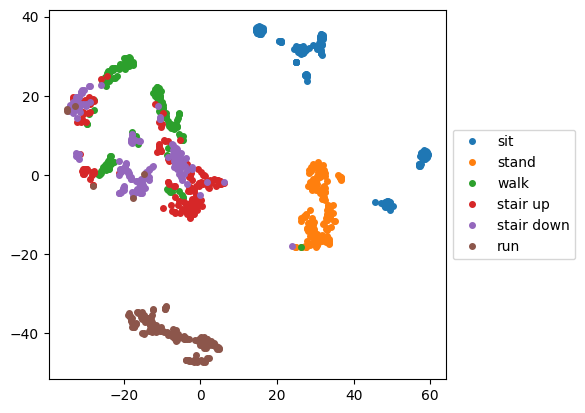

In [24]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [25]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


In [26]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

Epoch:1, P:None, Loss:2237.5375, Loss-ae:2226.8250, Loss-topo:10.7125
Epoch:2, P:None, Loss:2151.6718, Loss-ae:2150.3993, Loss-topo:1.2726
Epoch:3, P:None, Loss:743.8149, Loss-ae:736.2469, Loss-topo:7.5681
Epoch:4, P:None, Loss:628.1425, Loss-ae:623.4656, Loss-topo:4.6769
Epoch:5, P:None, Loss:544.3499, Loss-ae:537.7568, Loss-topo:6.5931
Epoch:6, P:None, Loss:510.8661, Loss-ae:505.2107, Loss-topo:5.6554
Epoch:7, P:None, Loss:475.0273, Loss-ae:471.6480, Loss-topo:3.3793
Epoch:8, P:None, Loss:329.8885, Loss-ae:320.5318, Loss-topo:9.3567
Epoch:9, P:None, Loss:296.6618, Loss-ae:291.8277, Loss-topo:4.8340
Epoch:10, P:None, Loss:301.5856, Loss-ae:297.2778, Loss-topo:4.3078
Epoch:11, P:None, Loss:264.0216, Loss-ae:258.9578, Loss-topo:5.0638
Epoch:12, P:None, Loss:244.8668, Loss-ae:240.5951, Loss-topo:4.2718
Epoch:13, P:None, Loss:259.7724, Loss-ae:253.2849, Loss-topo:6.4875
Epoch:14, P:None, Loss:202.2862, Loss-ae:193.3861, Loss-topo:8.9001
Epoch:15, P:None, Loss:177.4735, Loss-ae:170.1982, L

KeyboardInterrupt: 

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [ ]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [ ]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [ ]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [ ]:
# Reducing with Convolutional Topological Autoencoders

In [ ]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [ ]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [ ]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result